# Project - AI for Medical Diagnosis and Prediction | Week #3

In this notebook, we continue our analysis of the MIMIC-CXR dataset by training our first classifiers. The objective is to perform a benchmark analysis of several machine learning classifiers to detect the presence of pathologies in chest x-rays.

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Create two subsets of the dataset: train and test <i>(Task 1)</i> <br>
- Prepare a list of models and hyperparameters to investigate during optimization <i>(Task 2)</i> <br>
- Implement the search using the cross-validation strategy of your choice <i>(Task 2*)</i> <br>
- Add an evaluation of data augmentation strategies as part of your optimization process <i>(Task 3)</i> <br>
- Run the benchmark analysis, save the results in a csv file using various appropriate metrics <i>(Task 4)</i> <br>
- Save the best model on the validation set <i>(Task 5)</i> <br>
- Compute the performance of this best model on the test set <i>(Task 5*)</i> <br>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [1]:
%pip install pydicom pynrrd -q
%pip install -q SimpleITK numpy PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import pydicom
import nrrd

import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
import warnings

warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = './MIMIC-CXR'

In [4]:
!curl https://uni-bonn.sciebo.de/s/XbomHCb6yL6nYN4/download/radiomics.csv --output ./radiomics.csv
!curl https://uni-bonn.sciebo.de/s/e7fKPxDYcs83J67/download/labels.csv --output ./labels.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1256k  100 1256k    0     0   998k      0  0:00:01  0:00:01 --:--:--  998k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63894  100 63894    0     0  87401      0 --:--:-- --:--:-- --:--:-- 87406


If you do not have the dataset anymore, please re-run the notebook from week 2. Here, we will use the csv file created during week 2: `radiomics.csv` which contains input features and target classes.

In [5]:
df = pd.read_csv(f'radiomics.csv')
labels_df = pd.read_csv(f'labels.csv')

In [6]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject_id,study_id,dicom_path,dicom_id,labels_encoded,pathology
0,-1.278524,0.855135,3.209739e+06,0.847227,1.163292,2.215956,1.373047,0.651548,-0.435326,-0.660705,...,0.000056,0.008836,0.001758,0.000056,18000291,55388853,files/p18/p18000291/s55388853/04564240-d4e9e69...,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
1,-1.313175,0.854954,3.300384e+06,0.839250,1.167722,2.261075,1.385948,0.657629,-0.451919,-0.669476,...,0.000060,0.008285,0.001627,0.000060,18000291,55388853,files/p18/p18000291/s55388853/ed82a88d-499bed8...,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
2,-1.128694,0.825043,9.963108e+05,0.868463,1.128072,2.452143,1.815657,0.622337,-0.358779,-0.610935,...,0.000126,0.010801,0.002224,0.000126,18000379,51062789,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
3,-1.029863,1.083006,1.473029e+06,0.993817,1.266049,1.926242,1.567053,0.647344,-0.021913,-0.097315,...,0.000052,0.015052,0.003731,0.000052,18000379,51568340,files/p18/p18000379/s51568340/3631ff3b-cfcb244...,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
4,-0.821600,1.128441,1.440104e+06,0.999173,1.235120,1.865436,1.651462,0.626043,0.091044,0.045712,...,0.000040,0.018150,0.004532,0.000040,18000379,51817182,files/p18/p18000379/s51817182/f6f04111-c3fde25...,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,[1 0 0 0 0 0 0 0 0 0 0 0 0 1],1


## Task 1 - Dataset split
* Get the list of **UNIQUE** patients ;
* Split the list into train and test patients ;
* Extract two datasets: `train_df` and `test_df`

In [7]:
patient_list =df['subject_id'].unique()

In [8]:
from sklearn.model_selection import train_test_split

patient_train, patient_test = train_test_split(patient_list, test_size=0.2, random_state=42)

In [9]:
train_df = df.loc[df['subject_id'].isin(patient_train)]
test_df = df.loc[df['subject_id'].isin(patient_test)]

train_labels_df = labels_df.loc[labels_df['subject_id'].isin(patient_train)]
test_labels_df = labels_df.loc[labels_df['subject_id'].isin(patient_test)]

# Save labels for future use
train_labels_df.to_csv('train_labels.csv', index=False)
test_labels_df.to_csv('test_labels.csv', index=False)

<div class="alert alert-block alert-info">
Visualize the repartition of classes across train and test set. Is there any imbalance?
</div>

In [10]:
train_df['pathology'].value_counts()

,count
pathology,
0,275
1,272


In [11]:
test_df['pathology'].value_counts()

,count
pathology,
1,68
0,54


In [13]:
X_train = train_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology'], axis=1)
y_train = train_df['pathology']

X_test = test_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology'], axis=1)
y_test = test_df['pathology']

## Task 2 - Models and hyperparameters

* Define the list of models and hyperparameters you want to benchmark ;
* Implement the cross-validation strategy of your choice ;
* Create the searcher and run the benchmark analysis.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Define models and hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), {
        'classifier__C': [0.01, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear']
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [10, 30, 50],
        'classifier__max_depth': [None, 5, 10]
    }),
    'Nearest Neighbors': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [5, 10, 20]
    }),
    #'MLP': (MLPClassifier(), {
    #    'classifier__hidden_layer_sizes':[100, 50, 15],
    #    'classifier__alpha':[0.01, 0.1, 0.5, 1]
    #})
}

# Use StratifiedKFold for cross-validation to maintain class proportions
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []
results_smote = []

In [15]:
# Run benchmark with hyperparameter tuning (without SMOTE)
for name, (model, param_dist) in models.items():
    # Create a pipeline with StandardScaler and the classifier.
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10,
                                scoring='recall', cv=cv, random_state=42, n_jobs=-1, error_score='raise')

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_score = search.best_score_
    std_dev = search.cv_results_['std_test_score'][search.best_index_]

    # Save best model into pkl format
    joblib.dump(best_model, f'best_model_{name.replace(" ", "_").lower()}.pkl')

    results.append({
        'Model': name,
        'Mean score': best_score,
        'Std Dev': std_dev
    })

## Task 3 - Data augmentation

* Add a data augmentation step in the pipeline, for instance using SMOTE ;
* Run the benchmark analysis using the data augmentation step.

In [16]:
# Run benchmark with hyperparameter tuning, scaling, and SMOTE
for name, (model, param_dist) in models.items():
    # Create a full pipeline with StandardScaler, SMOTE, and the classifier.
    # This is the correct order of operations.
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10,
                                scoring='recall', cv=cv, random_state=42, n_jobs=-1, error_score='raise')

    search.fit(X_train, y_train)

    # search.best_estimator_ is the entire tuned pipeline
    best_pipeline = search.best_estimator_
    best_score = search.best_score_
    std_dev = search.cv_results_['std_test_score'][search.best_index_]

    # Save the best pipeline (scaler + smote + model)
    joblib.dump(best_pipeline, f'best_model_smote_{name.replace(" ", "_").lower()}.pkl')

    results.append({
        'Model': name + ' SMOTE',
        'Mean score': best_score,
        'Std Dev': std_dev
    })

## Task 4 - Model selection

* Analyse the results provided by the benchmark analysis and select the best model ;
* Visualize different scores and comment.

In [18]:
# Create results table
df_results = pd.DataFrame(results).sort_values(by='Mean score', ascending=False)

print("Benchmark Results:")
print(df_results)

# Optionally: save to CSV
df_results.to_csv('model_benchmark_results_smote.csv', index=False)

Benchmark Results:
                       Model  Mean score   Std Dev
4        Random Forest SMOTE    0.761131  0.026594
1              Random Forest    0.750020  0.018367
0        Logistic Regression    0.709605  0.054569
3  Logistic Regression SMOTE    0.709565  0.058331
5    Nearest Neighbors SMOTE    0.665527  0.060616
2          Nearest Neighbors    0.661864  0.065650


<div class="alert alert-block alert-info">
Which model is the best performing one? <br>
Is there any benefits of data augmentation? <br>
Observe the metrics and comment on the expected behavior of the model for clinical practice.
</div>

The best-performing model is Random Forest with SMOTE.

It achieved the highest mean score of 0.761131. This means it has the best recall out of all the models tested, correctly identifying the highest percentage of positive cases during cross-validation. The standard Random Forest model was a close second, but the addition of SMOTE provided a slight performance boost.

Benefits of Data Augmentation (SMOTE):
Modest benefit to using SMOTE, but it depends on the model.

For Random Forest and Nearest Neighbors: SMOTE improved the recall score. The effect was most noticeable on the best model, Random Forest, pushing its score from 0.750 to 0.761.

For Logistic Regression: SMOTE had a negligible (and slightly negative) effect, with the score barely changing.

This suggests that data augmentation is most helpful for the non-linear models (Random Forest and KNN) in this dataset. For the best model, the benefit is clear, even if it's small. It successfully helped the model learn to identify more positive cases.

Clinical Practice Interpretation

A recall score of 0.761 for the best model (Random Forest with SMOTE) means that when used in a clinical setting, it is expected to correctly identify 76% of all patients who genuinely have the pathology.

As a Screening Tool: The model shows promise as a first-pass screening or assistance tool. It can successfully flag over three-quarters of positive cases, helping doctors prioritize patients or drawing attention to potentially overlooked signs in a chest X-ray.

False Negatives: The model is expected to miss 24% of patients who are actually sick. These "false negatives" are patients the model incorrectly labels as healthy.

Because of the risk of false negatives (24%), this model cannot be used as a standalone diagnostic tool. It is not reliable enough to replace a human radiologist. Instead, it should be used to support a clinician's decision-making process.

## Task 5 - Evaluation

* Load the selected model ;
* Make a full performance report (ROC curve, metrics, confusion matrices) of the selected model.

In [20]:
import joblib
from sklearn.metrics import classification_report

# Load the best performing model from analysis (Random Forest with SMOTE)
best_model = joblib.load('best_model_smote_random_forest.pkl')

# Use the loaded pipeline to make predictions on the test set
predictions = best_model.predict(X_test)

# Get the detailed classification report
print("Classification Report on the Test Set:")
print(classification_report(y_test, predictions))

Classification Report on the Test Set:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59        54
           1       0.67      0.60      0.64        68

    accuracy                           0.61       122
   macro avg       0.61      0.62      0.61       122
weighted avg       0.62      0.61      0.62       122



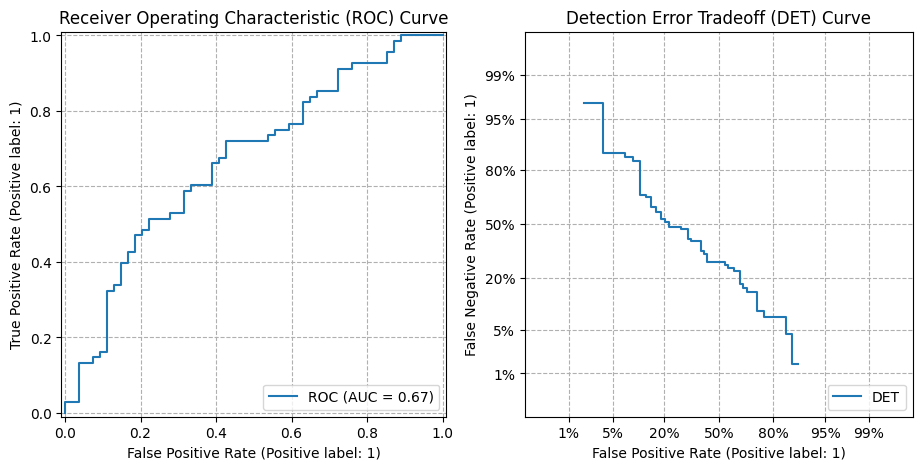

In [22]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Create the figure for the plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

# Plot the ROC and DET curves using the best model
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_roc, name='ROC')
DetCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_det, name='DET')

# Set titles and grids
ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve")
ax_det.set_title("Detection Error Tradeoff (DET) Curve")
ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

# The legend is automatically handled by the display objects, so plt.legend() is not needed
plt.show()

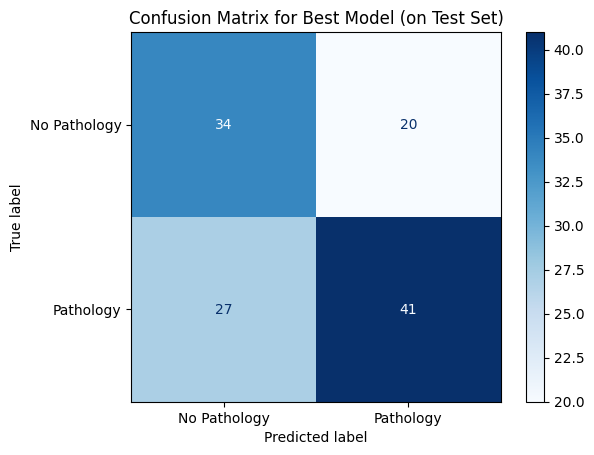

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use the best model to predict labels for the test set
predictions = best_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=best_model.classes_)

# Create the display object and plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Pathology', 'Pathology'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Best Model (on Test Set)')
plt.show()

#Final Performance Report: Random Forest with SMOTE
This report provides a final evaluation of the selected best-performing model, the Random Forest with SMOTE, based on its performance against the unseen test set of 122 patients. The analysis synthesizes the confusion matrix, key classification metrics, and the ROC curve to offer a complete picture of the model's clinical viability.

The model's performance is detailed in the confusion matrix, which breaks down its predictions. Out of 122 cases, the model made a total of 75 correct predictions, comprising 34 True Negatives (healthy patients correctly identified) and 41 True Positives (sick patients correctly identified). However, the model also produced 47 errors. These included 20 False Positives, where healthy patients were incorrectly flagged as having a pathology, and more critically, 27 False Negatives, where sick patients were missed entirely and incorrectly classified as healthy. This high number of misses is the most significant finding from the evaluation.

These counts translate into several performance metrics. Most importantly for this diagnostic task, the model achieved a recall (or sensitivity) of 60%. This means it successfully identified only 60% of all patients who had a pathology, while the remaining 40% were missed. The model's precision was 67%, indicating that when it did predict a pathology, it was correct about two-thirds of the time. Complementing the recall, the model's specificity was 63%, showing its ability to correctly identify healthy individuals. The overall accuracy was 61%. These metrics are supported by the ROC curve's Area Under the Curve (AUC) of 0.67, which signifies that the model possesses a modest, but better-than-random, ability to distinguish between sick and healthy patients.

Clinical Conclusion and Recommendation
While the model demonstrates a predictive capability superior to random chance, its performance on the test set reveals a critical weakness. The recall of 60% and the corresponding 27 false negatives are concerns in a clinical context, as missing 40% of sick patients is a high risk. Therefore, this model is not suitable for use as a standalone or primary diagnostic tool. It is best suited for deployment as a supportive screening aid for a human expert.